# Computational Statistics - Project
## Authors : Aurélie Wasem & Marcelo Tavares

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


In [ ]:
np.random.seed(42)

train_df = pd.read_csv('data/train.csv')

cat_vars = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'OverallQual',
    'OverallCond',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

for col in cat_vars:
    train_df[col] = train_df[col].astype('category')

salePrice = 'SalePrice'


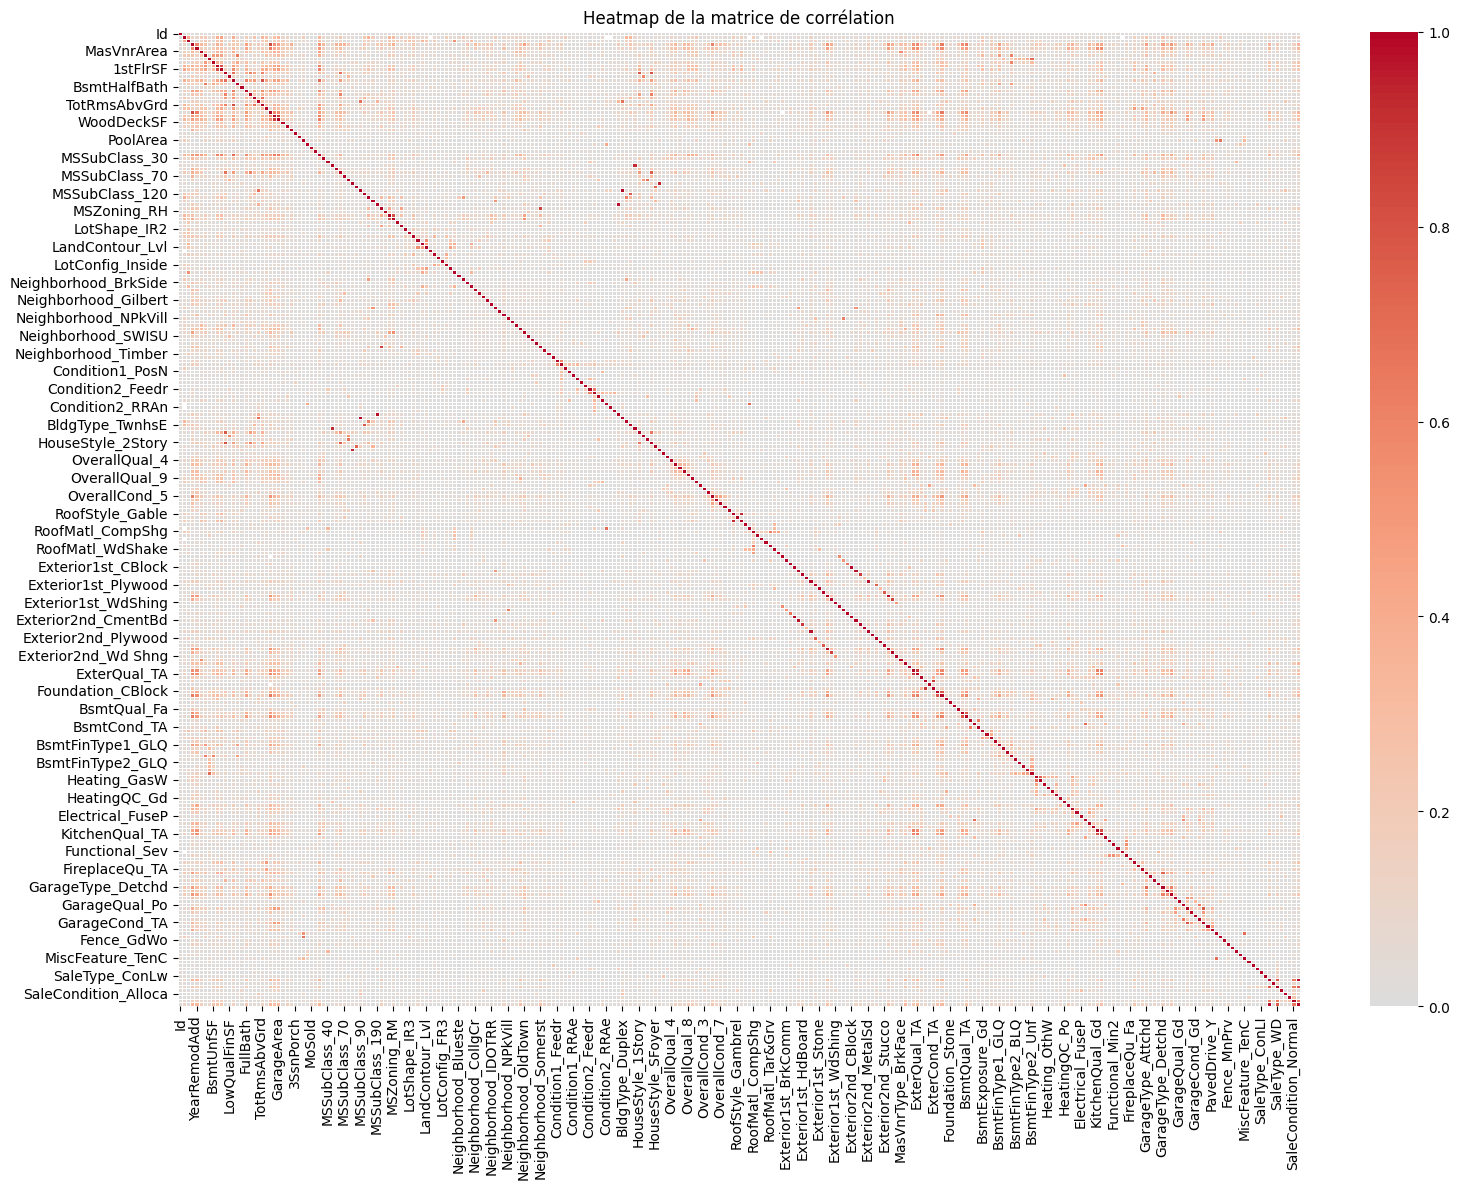

In [52]:
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(train_df, drop_first=True, dtype=int)

# Calculer la matrice de corrélation
corr_matrix = df_encoded.corr(numeric_only=True).abs()

# Sélectionner les corrélations > 0.9 (et pas la diagonale)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Tracer la heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title('Heatmap de la matrice de corrélation')
plt.tight_layout()
plt.show()

# Trouver les colonnes à supprimer (fortement corrélées)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Supprimer ces colonnes du DataFrame
df_encoded = df_encoded.drop(columns=to_drop)

            Feature  Importance
23       GarageCars    0.332181
13        GrLivArea    0.214571
9       TotalBsmtSF    0.054074
3         YearBuilt    0.051593
10         1stFlrSF    0.044869
6        BsmtFinSF1    0.030994
11         2ndFlrSF    0.020646
169    ExterQual_Gd    0.018655
4      YearRemodAdd    0.017827
214  KitchenQual_TA    0.015820
24       GarageArea    0.014263
119   OverallQual_8    0.012415
2           LotArea    0.011488
16         FullBath    0.010045
21       Fireplaces    0.008515
22      GarageYrBlt    0.008496
5        MasVnrArea    0.007531
1       LotFrontage    0.007495
20     TotRmsAbvGrd    0.006934
26      OpenPorchSF    0.005539


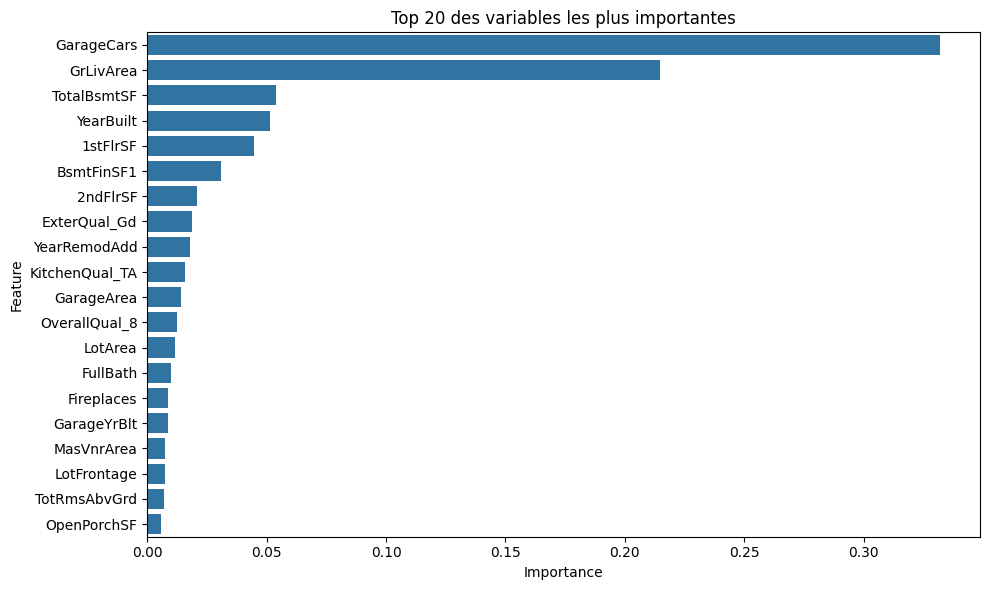

In [53]:
# Séparation des features et de la cible
X = df_encoded.drop(columns=["SalePrice"])  # ou ta variable cible
y = df_encoded["SalePrice"]

# Initialiser le modèle
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Calcul de l'importance des variables
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 des variables les plus importantes")
plt.tight_layout()
plt.show()


In [ ]:
# Sélection des variables avec Importance > 0.01
top_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()

grades = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1
}

# Création du DataFrame filtré avec uniquement les top features
top_features_df = df_encoded[top_features].drop(columns=['ExterQual_Gd','KitchenQual_TA','OverallQual_8'])
top_features_df['ExterQual'] = train_df['ExterQual'].map(grades).astype('category')
top_features_df['KitchenQual'] = train_df['KitchenQual'].map(grades).astype('category')
top_features_df['OverallQual'] = train_df['OverallQual']
top_features_df['SalePrice'] = y 

top_features_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,1stFlrSF,BsmtFinSF1,2ndFlrSF,YearRemodAdd,GarageArea,LotArea,FullBath,ExterQual,KitchenQual,OverallQual,SalePrice
0,2,1710,856,2003,856,706,854,2003,548,8450,2,4,4,7,208500
1,2,1262,1262,1976,1262,978,0,1976,460,9600,2,3,3,6,181500
2,2,1786,920,2001,920,486,866,2002,608,11250,2,4,4,7,223500
3,3,1717,756,1915,961,216,756,1970,642,9550,1,3,4,7,140000
4,3,2198,1145,2000,1145,655,1053,2000,836,14260,2,4,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,953,0,694,2000,460,7917,2,3,3,6,175000
1456,2,2073,1542,1978,2073,790,0,1988,500,13175,2,3,3,6,210000
1457,1,2340,1152,1941,1188,275,1152,2006,252,9042,2,5,4,7,266500
1458,1,1078,1078,1950,1078,49,0,1996,240,9717,1,3,4,5,142125


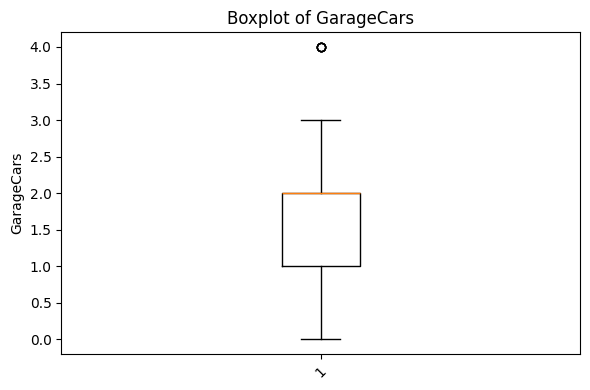

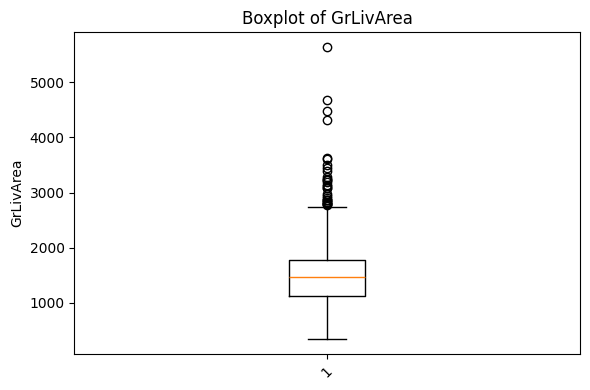

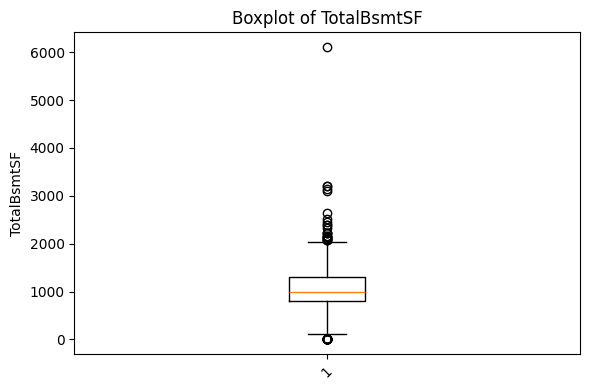

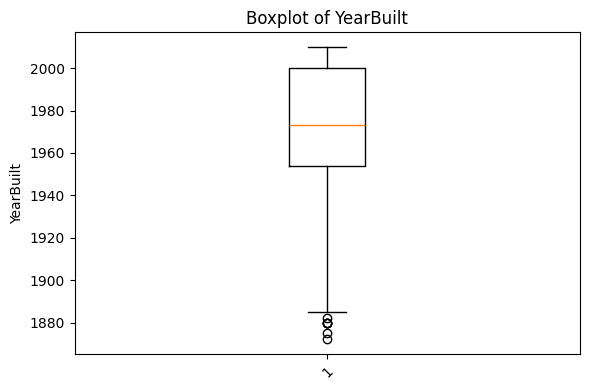

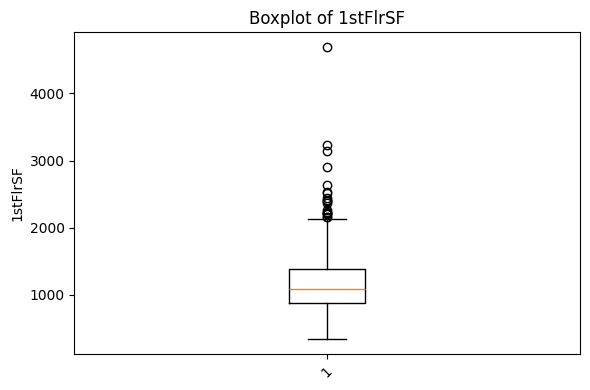

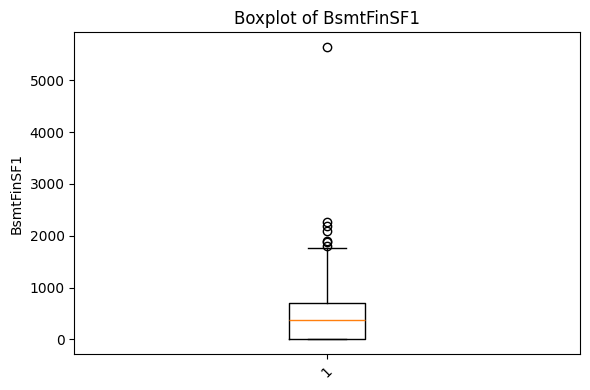

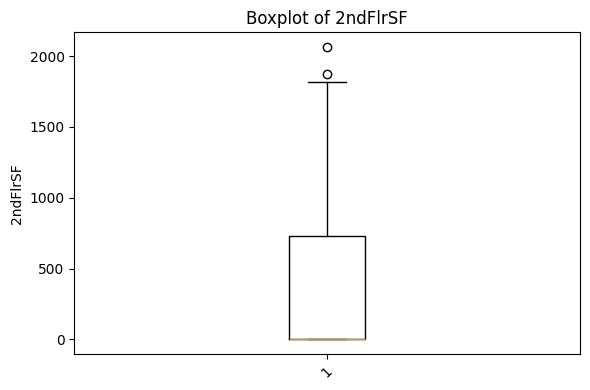

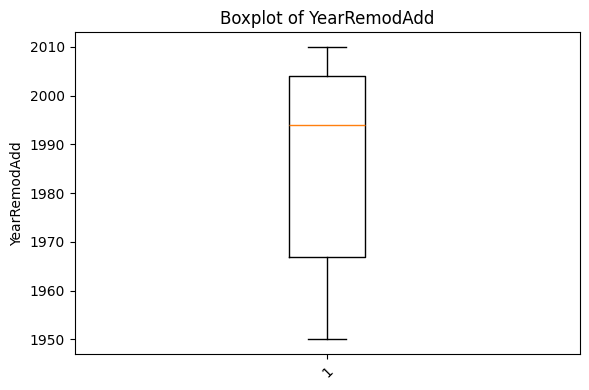

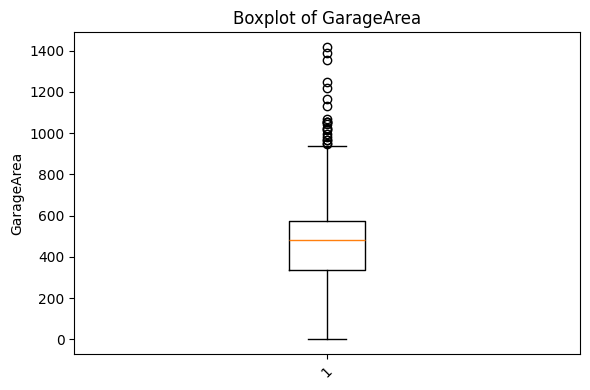

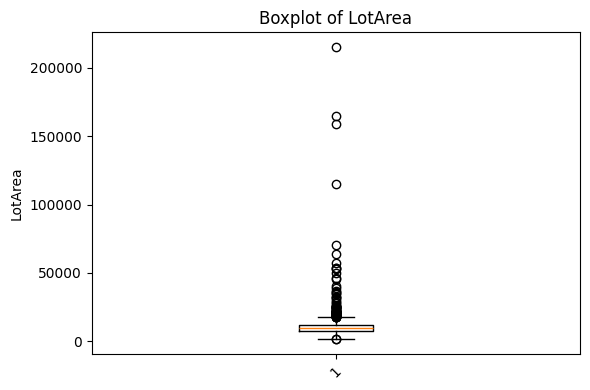

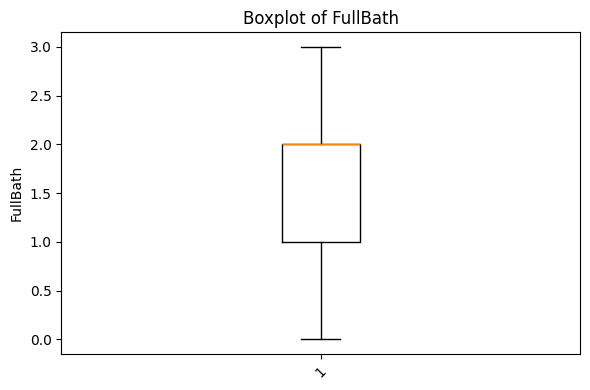

<Figure size 600x400 with 0 Axes>

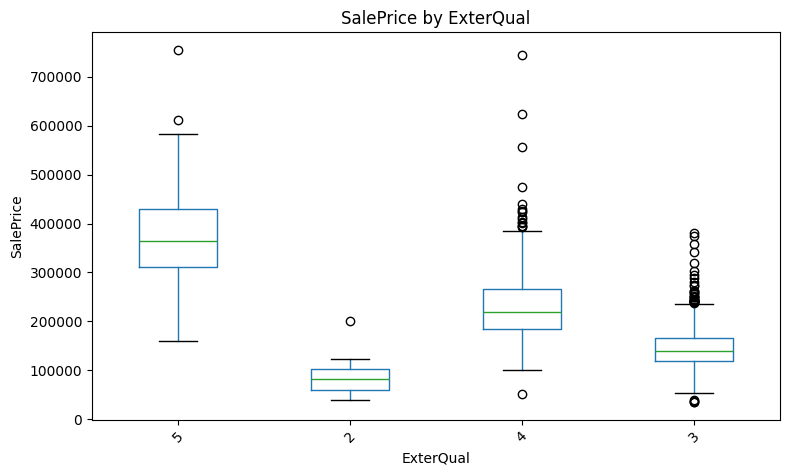

<Figure size 600x400 with 0 Axes>

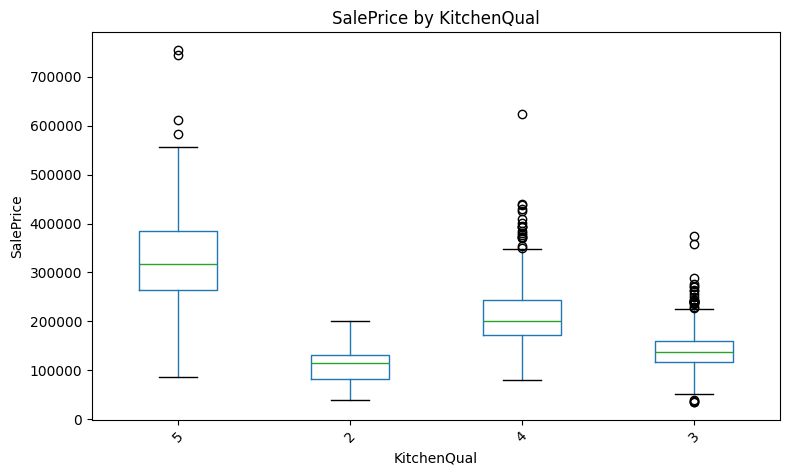

<Figure size 600x400 with 0 Axes>

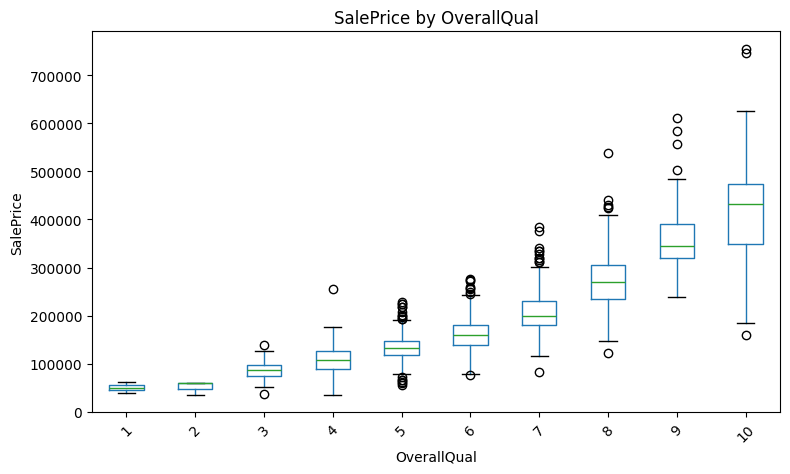

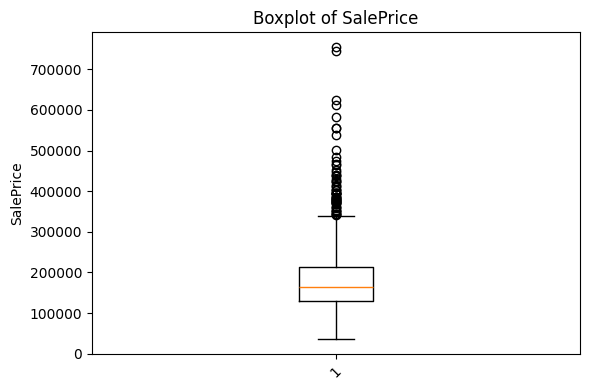

GarageCars         int64
GrLivArea          int64
TotalBsmtSF        int64
YearBuilt          int64
1stFlrSF           int64
BsmtFinSF1         int64
2ndFlrSF           int64
YearRemodAdd       int64
GarageArea         int64
LotArea            int64
FullBath           int64
ExterQual       category
KitchenQual     category
OverallQual     category
SalePrice          int64
dtype: object


In [21]:
# Parcourir toutes les colonnes
for column in top_features_df.columns:
    plt.figure(figsize=(6, 4))
    if top_features_df[column].dtype in ['int64', 'float64']:
        # Boxplot classique pour les colonnes numériques
        plt.boxplot(top_features_df[column].dropna())
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)
    else:
        # Boxplot SalePrice par modalité pour les colonnes qualitatives
        if salePrice in top_features_df.columns:
            try:
                top_features_df.boxplot(column='SalePrice', by=column, grid=False, figsize=(8, 5))
                plt.title(f'SalePrice by {column}')
                plt.suptitle('')
                plt.ylabel("SalePrice")
            except:
                plt.close()  # Certaines colonnes peuvent poser problème si trop de catégories uniques

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.close()

print(top_features_df.dtypes)


In [22]:
# Fonction pour détecter les outliers via la méthode IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Stocker les seuils pour chaque variable
outlier_bounds = []
outlier_filtered_df = top_features_df.copy()

for var in top_features_df.columns:
    if not pd.api.types.is_numeric_dtype(top_features_df[var]) or pd.api.types.is_bool_dtype(top_features_df[var]):
        continue
    if var == 'SalePrice':
        continue
    series = top_features_df[var].dropna()
    lower, upper = detect_outliers_iqr(series)

    # Enregistrer les bornes
    outlier_bounds.append({
        'Variable': var,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Nb Outliers (low)': (series < lower).sum(),
        'Nb Outliers (high)': (series > upper).sum()
    })

    # Supprimer les outliers dans une copie du DataFrame
    outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[var] >= lower) & (outlier_filtered_df[var] <= upper)]

# Gestion des valeurs extrêmes pour SalePrice
series = top_features_df[salePrice].dropna()
lower, upper = detect_outliers_iqr(series)
outlier_bounds.append({
    'Variable': salePrice,
    'Lower Bound': lower,
    'Upper Bound': upper,
    'Nb Outliers (low)' : (series < lower).sum(),
    'Nb Outliers (high)': (series > upper).sum()
})

outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[salePrice] >= lower) & (outlier_filtered_df[salePrice] <= upper)]

# Résumé sous forme de tableau
outlier_bounds_df = pd.DataFrame(outlier_bounds)

# Enregistrer le DataFrame filtré sans outliers pour usage futur
filtered_df = outlier_filtered_df.copy().filter(top_features_df.columns)
filtered_df

,GarageCars,GrLivArea,TotalBsmtSF,YearBuilt,1stFlrSF,BsmtFinSF1,2ndFlrSF,YearRemodAdd,GarageArea,LotArea,FullBath,ExterQual,KitchenQual,OverallQual,SalePrice
0,2,1710,856,2003,856,706,854,2003,548,8450,2,4,4,7,208500
1,2,1262,1262,1976,1262,978,0,1976,460,9600,2,3,3,6,181500
2,2,1786,920,2001,920,486,866,2002,608,11250,2,4,4,7,223500
3,3,1717,756,1915,961,216,756,1970,642,9550,1,3,4,7,140000
4,3,2198,1145,2000,1145,655,1053,2000,836,14260,2,4,4,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,1647,953,1999,953,0,694,2000,460,7917,2,3,3,6,175000
1456,2,2073,1542,1978,2073,790,0,1988,500,13175,2,3,3,6,210000
1457,1,2340,1152,1941,1188,275,1152,2006,252,9042,2,5,4,7,266500
1458,1,1078,1078,1950,1078,49,0,1996,240,9717,1,3,4,5,142125


In [23]:
import statsmodels.api as sm

# Variables pour la régression linéaire
X = filtered_df.drop(columns='SalePrice')
y = filtered_df['SalePrice']

# Ajouter la constante (intercept) au modèle
X = sm.add_constant(X)

# Construire et ajuster le modèle
model = sm.OLS(y, X).fit()

# Résumé du modèle
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     602.0
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        14:12:11   Log-Likelihood:                -14398.
No. Observations:                1268   AIC:                         2.883e+04
Df Residuals:                    1253   BIC:                         2.890e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.765e+05   8.34e+04    -11.710      0.000   -1.14e+06   -8.13e+05
GarageCars     -67.0835   1942.681     -0.035      0.972   -3878.349    3744.182
GrLivArea       20.7971     13.939      1.492      0.136      -6.548      48.143
TotalBsmtSF     23.9517      4.265      5.615      0.000      15.584      32.320
YearBuilt      202.8970     32.311      6.279      0.000     139.507     266.287
1stFlrSF        18.9611     14.553      1.303      0.193      -9.590      47.513
BsmtFinSF1      19.7596      1.640     12.051      0.000      16.543      22.977
2ndFlrSF        26.0102     14.007      1.857      0.064      -1.470      53.490
YearRemodAdd   245.6214     40.931      6.001      0.000     165.320     325.923
GarageArea      24.0426      6.748      3.563      0.000      10.804      37.281
LotArea          2.2244      0.211     10.527      0.000       1.810       2.639
FullBath     -4198.3987   1661.259     -2.527      0.012   -7457.555    -939.242
ExterQual     9830.6687   1789.367      5.494      0.000    6320.184    1.33e+04
KitchenQual   8906.6483   1436.330      6.201      0.000    6088.772    1.17e+04
OverallQual   1.287e+04    799.105     16.106      0.000    1.13e+04    1.44e+04
==============================================================================
Omnibus:                       65.710   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.737
Skew:                          -0.145   Prob(JB):                     1.73e-46
Kurtosis:                       4.976   Cond. No.                     1.46e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# DataFrame pour stocker les résultats
regression_results = []
stat_utilities_df = filtered_df.copy()
print(filtered_df.dtypes)

stat_utilities_df['ExterQual'] = stat_utilities_df['ExterQual'].astype('int')
stat_utilities_df['OverallQual'] = stat_utilities_df['OverallQual'].astype('int')
stat_utilities_df['KitchenQual'] = stat_utilities_df['ExterQual'].astype('int')

# Pour chaque variable (sauf SalePrice), on fait une régression simple
for var in stat_utilities_df.columns:
    
    mean = stat_utilities_df[var].dropna().mean()
    variance = stat_utilities_df[var].dropna().var()

    if var == 'SalePrice':
        regression_results.append({
            'Variable': var,
            'Mean': mean,
            'Variance': variance,
            'Coefficient': '-',
            'CI 95% Lower': '-',
            'CI 95% Upper': '-',
            'T-statistic (H0: impact)': '-',
            'P-value': '-',
            'Significatif ?': '-'
        })
    else:
        # Préparation des données
        X = stat_utilities_df[[var]].dropna()
        y = stat_utilities_df.loc[X.index, 'SalePrice']
        
        # Régression linéaire avec sklearn
        model = LinearRegression().fit(X, y)
        coef = model.coef_[0]
        intercept = model.intercept_
        
        # Prédictions et erreur standard du coefficient
        y_pred = model.predict(X)
        residuals = y - y_pred
        n = len(y)
        X_mean = np.mean(X[var])
        s_squared = np.sum((residuals)**2) / (n - 2)
        se_beta = np.sqrt(s_squared / np.sum((X[var] - X_mean)**2))
        
        # Statistiques du test d'hypothèse H0: beta ≠ 0 (impact significatif)
        t_stat = coef / se_beta
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - 2))
        
        # Intervalle de confiance à 95% du coefficient
        ci_low = coef - stats.t.ppf(0.975, df=n - 2) * se_beta
        ci_high = coef + stats.t.ppf(0.975, df=n - 2) * se_beta
        
        regression_results.append({
            'Variable': var,
            'Mean': mean,
            'Variance': variance,
            'Coefficient': coef,
            'CI 95% Lower': ci_low,
            'CI 95% Upper': ci_high,
            'T-statistic (H0: impact)': t_stat,
            'P-value': p_value,
            'Significatif ?': 'Oui' if p_value < 0.05 else 'Non'
        })

regression_df = pd.DataFrame(regression_results)

regression_df

GarageCars         int64
GrLivArea          int64
TotalBsmtSF        int64
YearBuilt          int64
1stFlrSF           int64
BsmtFinSF1         int64
2ndFlrSF           int64
YearRemodAdd       int64
GarageArea         int64
LotArea            int64
FullBath           int64
ExterQual       category
KitchenQual     category
OverallQual     category
SalePrice          int64
dtype: object


,Variable,Mean,Variance,Coefficient,CI 95% Lower,CI 95% Upper,T-statistic (H0: impact),P-value,Significatif ?
0,GarageCars,1.697950,4.966967e-01,53046.663722,49633.917346,56459.410098,30.494222,0.0,Oui
1,GrLivArea,1436.347792,1.766376e+05,94.646135,89.208045,100.084225,34.144439,0.0,Oui
2,TotalBsmtSF,1028.768139,1.065950e+05,101.694805,93.776965,109.612646,25.197388,0.0,Oui
3,YearBuilt,1971.123817,8.845032e+02,1190.655182,1106.783658,1274.526706,27.850626,0.0,Oui
4,1stFlrSF,1105.524448,9.960849e+04,101.466105,93.133286,109.798923,23.888703,0.0,Oui
5,BsmtFinSF1,417.198738,1.563504e+05,42.223046,34.557736,49.888356,10.806457,0.0,Oui
6,2ndFlrSF,326.154574,1.659200e+05,41.156291,33.718152,48.594431,10.85514,0.0,Oui
7,YearRemodAdd,1984.626183,4.225831e+02,1557.053436,1429.0922,1685.014671,23.871988,0.0,Oui
8,GarageArea,451.333596,3.743160e+04,186.959308,174.239239,199.679378,28.835075,0.0,Oui
9,LotArea,9075.248423,9.887296e+06,6.962519,6.031138,7.8939,14.665694,0.0,Oui


In [55]:
# Création d'une copie du DataFrame avec des noms compatibles pour la formule
df_formula = filtered_df.copy()

# Renommer les colonnes problématiques
df_formula = df_formula.rename(columns={
    '1stFlrSF': 'FirstFlrSF',
    '2ndFlrSF': 'SecondFlrSF'
})

# Mettre à jour la liste des variables avec les nouveaux noms
quant_vars_formula = [
    'FirstFlrSF' if var == '1stFlrSF'
    else 'SecondFlrSF' if var == '2ndFlrSF'
    else var
    for var in top_features_df.columns
    if var != 'SalePrice'
]

# Construire la formule pour la régression multiple
formula = 'SalePrice ~ ' + ' + '.join(quant_vars_formula)

# Ajuster le modèle
multi_model = smf.ols(formula=formula, data=df_formula).fit()

# Table ANOVA
anova_table = sm.stats.anova_lm(multi_model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})

# Ajouter colonne MS (Mean Square = SS / DF)
anova_table['MS'] = anova_table['SS'] / anova_table['DF']

# Ajouter colonne "Significatif ?"
anova_table['Significatif ?'] = anova_table['p_value'].apply(
    lambda p: 'NaN' if pd.isna(p) else ('Oui' if p < 0.05 else 'Non')
)
# Réorganiser les colonnes
anova_table = anova_table[['Variable', 'SS', 'DF', 'MS', 'F', 'p_value', 'Significatif ?']]

# Calcul de la somme des carrés totale (SS total) et DF total
ss_total = anova_table['SS'].sum()
df_total = anova_table['DF'].sum()

# Calcul de MS total (facultatif, ici on peut mettre NaN car ça n'a pas de signification directe)
ms_total = np.nan

# Ajout de la ligne 'Total' à la table ANOVA
anova_total_row= pd.DataFrame([{
    'Variable': 'Total',
    'SS': ss_total,
    'DF': df_total,
    'MS': ms_total,
    'F': np.nan,
    'p_value': np.nan,
    'Significatif ?': ''
}])

anova_table = pd.concat([anova_table, anova_total_row], ignore_index=True)


anova_table

,Variable,SS,DF,MS,F,p_value,Significatif ?
0,ExterQual,7.229318e+09,3.0,2.409773e+09,6.078801,4.172625e-04,Oui
1,KitchenQual,1.932532e+10,3.0,6.441772e+09,16.249770,2.308369e-10,Oui
2,OverallQual,1.276132e+11,9.0,1.417924e+10,35.768019,1.483275e-56,Oui
3,GarageCars,3.859160e+08,1.0,3.859160e+08,0.973497,3.240019e-01,Non
4,GrLivArea,9.379713e+08,1.0,9.379713e+08,2.366091,1.242521e-01,Non
5,TotalBsmtSF,1.068936e+10,1.0,1.068936e+10,26.964582,2.419541e-07,Oui
6,YearBuilt,2.235859e+10,1.0,2.235859e+10,56.400939,1.125461e-13,Oui
7,FirstFlrSF,6.674123e+08,1.0,6.674123e+08,1.683589,1.946894e-01,Non
8,BsmtFinSF1,6.304808e+10,1.0,6.304808e+10,159.042698,2.134624e-34,Oui
9,SecondFlrSF,1.510070e+09,1.0,1.510070e+09,3.809244,5.119513e-02,Non


In [56]:
# Création des colonnes binarisées
factorial_df = stat_utilities_df.copy()

binarized_cols = []

for var in factorial_df.drop(columns='SalePrice').columns:
    median = factorial_df[var].median()
    bin_col = f"{var}_bin"
    factorial_df[bin_col] = factorial_df[var].apply(lambda x: 1 if x >= median else -1)
    binarized_cols.append(bin_col)

# Extraire uniquement les colonnes binaires créées
binarized_df = factorial_df[binarized_cols]

binarized_df

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,1stFlrSF_bin,BsmtFinSF1_bin,2ndFlrSF_bin,YearRemodAdd_bin,GarageArea_bin,LotArea_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin,OverallQual_bin
0,1,1,-1,1,-1,1,1,1,1,-1,1,1,1,1
1,1,-1,1,1,1,1,1,-1,-1,1,1,1,1,1
2,1,1,-1,1,-1,1,1,1,1,1,1,1,1,1
3,1,1,-1,-1,-1,-1,1,-1,1,1,-1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,-1,1,-1,-1,1,1,-1,-1,1,1,1,1
1456,1,1,1,1,1,1,1,-1,1,1,1,1,1,1
1457,-1,1,1,-1,1,-1,1,1,-1,-1,1,1,1,1
1458,-1,-1,1,-1,1,-1,1,1,-1,1,-1,1,1,-1


In [57]:
# Choisir 5 facteurs de base pour générer le plan 2^4
base_factors = ['GarageCars_bin', 'GrLivArea_bin', 'TotalBsmtSF_bin', 'YearBuilt_bin', '1stFlrSF_bin']

# Générer toutes les combinaisons possibles de -1/+1 pour les 5 facteurs de base (2^5 = 32 essais)
plan_2k = list(itertools.product([-1, 1], repeat=5))
plan_df = pd.DataFrame(plan_2k, columns=base_factors)

# Générer les aliasés pour compléter les 14 colonnes si besoin
plan_df['F'] = plan_df['GarageCars_bin'] * plan_df['GrLivArea_bin']
plan_df['G'] = plan_df['GarageCars_bin'] * plan_df['TotalBsmtSF_bin']
plan_df['H'] = plan_df['GarageCars_bin'] * plan_df['YearBuilt_bin']
plan_df['I'] = plan_df['GarageCars_bin'] * plan_df['1stFlrSF_bin']
plan_df['J'] = plan_df['GrLivArea_bin'] * plan_df['TotalBsmtSF_bin']
plan_df['K'] = plan_df['GrLivArea_bin'] * plan_df['YearBuilt_bin']
plan_df['L'] = plan_df['GrLivArea_bin'] * plan_df['1stFlrSF_bin']
plan_df['M'] = plan_df['TotalBsmtSF_bin'] * plan_df['YearBuilt_bin']
plan_df['N'] = plan_df['TotalBsmtSF_bin'] * plan_df['1stFlrSF_bin']
plan_df

,GarageCars_bin,GrLivArea_bin,TotalBsmtSF_bin,YearBuilt_bin,1stFlrSF_bin,F,G,H,I,J,K,L,M,N
0,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1
1,-1,-1,-1,-1,1,1,1,1,-1,1,1,-1,1,-1
2,-1,-1,-1,1,-1,1,1,-1,1,1,-1,1,-1,1
3,-1,-1,-1,1,1,1,1,-1,-1,1,-1,-1,-1,-1
4,-1,-1,1,-1,-1,1,-1,1,1,-1,1,1,-1,-1
5,-1,-1,1,-1,1,1,-1,1,-1,-1,1,-1,-1,1
6,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,1,-1
7,-1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,1,1
8,-1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1,1,1
9,-1,1,-1,-1,1,-1,1,1,-1,-1,-1,1,1,-1


In [ ]:
for var in base_factors:
    original_var = var.replace('_bin', '')
    median = factorial_df[original_var].median()
    factorial_df[var] = factorial_df[original_var].apply(lambda x: 1 if x >= median else -1)

# Associer les lignes du plan à des moyennes de SalePrice
saleprice_list = []
for _, row in plan_df.iterrows():
    condition = (factorial_df[base_factors[0]] == row[base_factors[0]])
    for col in base_factors[1:]:
        condition &= (factorial_df[col] == row[col])
    matched_rows = factorial_df[condition]
    mean_price = matched_rows['SalePrice'].mean() if not matched_rows.empty else None
    saleprice_list.append(mean_price)

plan_df['MeanSalePrice'] = saleprice_list
plan_df_cleaned = plan_df.dropna(subset=['MeanSalePrice']).copy()
# Renommer la colonne problématique
plan_df_cleaned = plan_df_cleaned.rename(columns={"1stFlrSF_bin": "FirstFlrSF_bin"})

# Régression
# Mettre à jour la formule avec les bons noms de colonnes
formula = 'MeanSalePrice ~ ' + ' + '.join(plan_df_cleaned.columns[:-1])

model = smf.ols(formula=formula, data=plan_df_cleaned).fit()

model.summary()


C:\Users\aurel\AppData\Local\Temp\ipykernel_14440\3688869575.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_full = pd.concat([anova_table, anova_total], ignore_index=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MeanSalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 13 May 2025   Prob (F-statistic):           3.64e-05
Time:                        16:28:16   Log-Likelihood:                -306.51
No. Observations:                  29   AIC:                             643.0
Df Residuals:                      14   BIC:                             663.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.518e+05   2653.317     57.207      0.000    1.46e+05    1.57e+05
GarageCars_bin   1.712e+04   2653.317      6.451      0.000    1.14e+04    2.28e+04
GrLivArea_bin    1.749e+04   2582.549      6.773      0.000     1.2e+04     2.3e+04
TotalBsmtSF_bin  7050.7369   2653.317      2.657      0.019    1359.937    1.27e+04
YearBuilt_bin    8267.2908   2653.317      3.116      0.008    2576.491     1.4e+04
FirstFlrSF_bin   6730.8700   2653.317      2.537      0.024    1040.070    1.24e+04
F                5569.1657   2582.549      2.156      0.049      30.148    1.11e+04
G                 208.7609   2653.317      0.079      0.938   -5482.039    5899.561
H                9686.4068   2653.317      3.651      0.003    3995.607    1.54e+04
I                1848.2188   2653.317      0.697      0.497   -3842.581    7539.019
J                -941.8466   2558.525     -0.368      0.718   -6429.337    4545.644
K                2829.1069   2582.549      1.095      0.292   -2709.911    8368.125
L                 -61.9824   2558.525     -0.024      0.981   -5549.473    5425.508
M                4203.3783   2653.317      1.584      0.135   -1487.422    9894.178
N                1640.1778   2653.317      0.618      0.546   -4050.622    7330.978
==============================================================================
Omnibus:                        0.170   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.919   Jarque-Bera (JB):                0.151
Skew:                          -0.139   Prob(JB):                        0.927
Kurtosis:                       2.781   Cond. No.                         1.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#ANOVA
anova_table = sm.stats.anova_lm(model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_full = pd.concat([anova_table, anova_total], ignore_index=True)
anova_full


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars_bin,7.648830e+09,1.0,41.618702,0.000015,7.648830e+09,Oui
1,GrLivArea_bin,8.431250e+09,1.0,45.875996,0.000009,8.431250e+09,Oui
2,TotalBsmtSF_bin,1.297768e+09,1.0,7.061397,0.018759,1.297768e+09,Oui
3,YearBuilt_bin,1.784245e+09,1.0,9.708408,0.007590,1.784245e+09,Oui
4,FirstFlrSF_bin,1.182689e+09,1.0,6.435229,0.023718,1.182689e+09,Oui
5,F,8.546523e+08,1.0,4.650321,0.048924,8.546523e+08,Oui
6,G,1.137696e+06,1.0,0.006190,0.938401,1.137696e+06,Non
7,H,2.449365e+09,1.0,13.327448,0.002621,2.449365e+09,Oui
8,I,8.917330e+07,1.0,0.485208,0.497476,8.917330e+07,Non
9,J,2.490505e+07,1.0,0.135513,0.718289,2.490505e+07,Non


In [61]:
# Liste des variables à garder (p-value < 0.05)
significant_vars = anova_full.loc[
    (anova_full['p_value'] < 0.05) & (anova_full['p_value'].notna()),
    'Variable'
].tolist()

# Adapter le DataFrame pour que les colonnes soient bien présentes
# Si FirstFlrSF_bin a été renommé dans les étapes précédentes, on le renomme ici pour cohérence
plan_df_cleaned = plan_df_cleaned.rename(columns={"1stFlrSF_bin": "FirstFlrSF_bin"})

# Construire la formule
formula = 'MeanSalePrice ~ ' + ' + '.join(significant_vars)

# Créer le modèle et le résumer
model_reduced = smf.ols(formula=formula, data=plan_df_cleaned).fit()
model_summary = model_reduced.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          MeanSalePrice   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     23.72
Date:                Tue, 13 May 2025   Prob (F-statistic):           1.28e-08
Time:                        16:35:49   Log-Likelihood:                -310.44
No. Observations:                  29   AIC:                             636.9
Df Residuals:                      21   BIC:                             647.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.523e+05   2414.539     63.064      0.000    1.47e+05    1.57e+05
GarageCars_bin   1.664e+04   2414.539      6.890      0.000    1.16e+04    2.17e+04
GrLivArea_bin    1.697e+04   2378.614      7.136      0.000     1.2e+04    2.19e+04
TotalBsmtSF_bin  6124.5136   2378.614      2.575      0.018    1177.915    1.11e+04
YearBuilt_bin    8748.7094   2414.539      3.623      0.002    3727.401    1.38e+04
FirstFlrSF_bin   7657.0933   2378.614      3.219      0.004    2710.495    1.26e+04
F                6088.2663   2378.614      2.560      0.018    1141.668     1.1e+04
H                9204.9882   2414.539      3.812      0.001    4183.679    1.42e+04
==============================================================================
Omnibus:                        2.392   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.183
Skew:                          -0.058   Prob(JB):                        0.554
Kurtosis:                       3.983   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
anova_table = sm.stats.anova_lm(model_reduced, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})
anova_table['MS'] = anova_table['SS'] / anova_table['DF']
anova_table['Significatif ?'] = anova_table['p_value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')

# Ligne Total
total_ss = anova_table['SS'].sum()
total_df = anova_table['DF'].sum()
anova_total = pd.DataFrame([{
    'Variable': 'Total',
    'SS': total_ss,
    'DF': total_df,
    'MS': None,
    'F': None,
    'p_value': None,
    'Significatif ?': ''
}])
anova_reduce = pd.concat([anova_table, anova_total], ignore_index=True)
anova_reduce

C:\Users\aurel\AppData\Local\Temp\ipykernel_14440\725565358.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_reduce = pd.concat([anova_table, anova_total], ignore_index=True)


,Variable,SS,DF,F,p_value,MS,Significatif ?
0,GarageCars_bin,7.622891e+09,1.0,47.470029,8.274346e-07,7.622891e+09,Oui
1,GrLivArea_bin,8.176518e+09,1.0,50.917625,4.894226e-07,8.176518e+09,Oui
2,TotalBsmtSF_bin,1.064622e+09,1.0,6.629721,1.766191e-02,1.064622e+09,Oui
3,YearBuilt_bin,2.108239e+09,1.0,13.128634,1.592988e-03,2.108239e+09,Oui
4,FirstFlrSF_bin,1.664103e+09,1.0,10.362867,4.116456e-03,1.664103e+09,Oui
5,F,1.052058e+09,1.0,6.551479,1.825865e-02,1.052058e+09,Oui
6,H,2.333879e+09,1.0,14.533761,1.016718e-03,2.333879e+09,Oui
7,Residual,3.372248e+09,21.0,NaN,NaN,1.605833e+08,Non
8,Total,2.739456e+10,28.0,NaN,NaN,NaN,
